# Clasificador de Imágenes: Piezas de ajedrez

In [3]:
import os
from pathlib import Path
import shutil

import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets

c:\Users\chess\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Utilizamos optuna para encontrar los mejores hiperparámetros

In [4]:
def objective(trial):
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    data_path = 'data/raw/Chess'    

    transform_train = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    full_data = datasets.ImageFolder(root=data_path, transform=transform_train)
    train_size = int(0.8 * len(full_data))
    test_size = len(full_data) - train_size
    train_data, test_data = random_split(full_data, [train_size, test_size])

    test_data.dataset.transform = transform_test

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    class ConvNet(nn.Module):
        def __init__(self, num_classes, dropout_rate):
            super(ConvNet, self).__init__()
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
            self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
            self.fc1 = nn.Linear(128 * 8 * 8, 256)
            self.dropout = nn.Dropout(dropout_rate)
            self.fc2 = nn.Linear(256, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_classes = len(full_data.classes)
    model = ConvNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    epochs = 5
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print("Best hyperparameters:", study.best_params)

[I 2024-12-03 23:00:45,709] A new study created in memory with name: no-name-cd86705a-5853-4725-b809-44b3482bc676
[I 2024-12-03 23:01:15,590] Trial 0 finished with value: 19.81981981981982 and parameters: {'batch_size': 16, 'lr': 0.010715067626093483, 'dropout_rate': 0.42280502668840336}. Best is trial 0 with value: 19.81981981981982.
[I 2024-12-03 23:01:45,661] Trial 1 finished with value: 24.324324324324323 and parameters: {'batch_size': 16, 'lr': 4.143661406481876e-05, 'dropout_rate': 0.10888774805105422}. Best is trial 1 with value: 24.324324324324323.
[I 2024-12-03 23:02:12,635] Trial 2 finished with value: 18.01801801801802 and parameters: {'batch_size': 128, 'lr': 1.3276021600447367e-05, 'dropout_rate': 0.4645233544523977}. Best is trial 1 with value: 24.324324324324323.
[I 2024-12-03 23:02:40,893] Trial 3 finished with value: 18.91891891891892 and parameters: {'batch_size': 32, 'lr': 0.0020820319528527783, 'dropout_rate': 0.16245264911126617}. Best is trial 1 with value: 24.324

Best hyperparameters: {'batch_size': 64, 'lr': 0.0018108019696562306, 'dropout_rate': 0.10786930708719576}


Creamos un clasificador básico usando los datos originales.

In [5]:
# Definimos las transformaciones para normalizar los datos
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Ruta de las imágenes
data_path = 'data/raw/Chess'

# Cargamos todas las imágenes de la carpeta con ImageFolder
full_data = datasets.ImageFolder(root=data_path, transform=transform)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba

train_data, test_data = random_split(full_data, [train_size, test_size])

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


In [6]:
class ConvNet(nn.Module):
    def __init__(self, classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ConvNet2(nn.Module):
    def __init__(self, classes):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #print(x.shape)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class ConvNet3(nn.Module):
    def __init__(self, classes):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):
        """
        Inicializa el criterio para la parada temprana.
        
        Args:
            tolerance (int): Número de épocas sin mejora para detener el entrenamiento.
            min_delta (float): La mínima mejora que se necesita en la pérdida de validación.
        """
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False
        self.best_val_loss = float('inf')

    def __call__(self, validation_loss):
        """
        Llama a la función con la pérdida de entrenamiento y de validación.
        
        Args:
            train_loss (float): La pérdida en el conjunto de entrenamiento.
            validation_loss (float): La pérdida en el conjunto de validación.
        """
        if (self.best_val_loss - validation_loss) > self.min_delta:
            self.counter = 0  
            self.best_val_loss = validation_loss
        else:
            self.counter += 1 
        
        if self.counter >= self.tolerance:
            self.early_stop = True
            print("Parada temprana activada. No hay mejora en la pérdida de validación.")

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_train_loss, accuracy

def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.numpy())

            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy, all_labels, all_preds

def plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, classes):
    """
    Genera gráficas de las métricas: pérdida y precisión, además de la matriz de confusión.
    """
    # Gráfico de pérdidas
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs_trained + 1), train_losses[:epochs_trained], label="Training Loss")
    plt.plot(range(1, epochs_trained + 1), test_losses[:epochs_trained], label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Test Loss")
    plt.legend()

    # Gráfico de precisión
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs_trained + 1), train_accuracies[:epochs_trained], label="Training Accuracy")
    plt.plot(range(1, epochs_trained + 1), test_accuracies[:epochs_trained], label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Training and Test Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Crear y graficar la matriz de confusión
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype=int)
    for true_label, pred_label in zip(all_labels, all_preds):
        confusion_matrix[true_label, pred_label] += 1

    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(confusion_matrix, cmap='Blues')
    plt.colorbar(cax)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes, rotation=45, ha="right")
    ax.set_yticklabels(classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="black")

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

def train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs, start_early_stop=1):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    epochs_trained = 0

    for epoch in range(epochs):
        # Entrenamiento por una época
        train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss}, Training Accuracy: {train_accuracy}%")

        # Evaluación en el conjunto de prueba
        test_loss, test_accuracy, all_labels, all_preds = evaluate(model, test_loader, criterion)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        print(f"Epoch {epoch + 1}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%")

        # Early stopping
        if early_stopping:
            early_stopping(test_loss)
            if early_stopping.early_stop and epoch>start_early_stop:
                print(f"Entrenamiento detenido en la época {epoch + 1} debido a la parada temprana.")
                epochs_trained = epoch + 1
                break
    else:
        epochs_trained = epochs

    # Graficar resultados
    plot_metrics(epochs_trained, train_losses, test_losses, train_accuracies, test_accuracies, all_labels, all_preds, model.classes)
    return model

Clasificador básico:

(Sin parada temprana)

Epoch 1, Training Loss: 1.8025960794516973, Training Accuracy: 16.55328798185941%
Epoch 1, Test Loss: 1.777855668749128, Test Accuracy: 18.91891891891892%
Epoch 2, Training Loss: 1.727083797965731, Training Accuracy: 26.077097505668934%
Epoch 2, Test Loss: 1.7930819477353777, Test Accuracy: 22.52252252252252%
Epoch 3, Training Loss: 1.6248255457196916, Training Accuracy: 34.240362811791385%
Epoch 3, Test Loss: 1.772600531578064, Test Accuracy: 27.027027027027028%
Epoch 4, Training Loss: 1.5136880746909551, Training Accuracy: 41.723356009070294%
Epoch 4, Test Loss: 1.7795876264572144, Test Accuracy: 28.82882882882883%
Epoch 5, Training Loss: 1.3084265461989812, Training Accuracy: 53.06122448979592%
Epoch 5, Test Loss: 1.8309327704565865, Test Accuracy: 30.63063063063063%
Epoch 6, Training Loss: 1.1881312046732222, Training Accuracy: 54.64852607709751%
Epoch 6, Test Loss: 1.7826361996786935, Test Accuracy: 27.027027027027028%
Epoch 7, Training Loss: 1.0096785830599921, Training Accuracy:

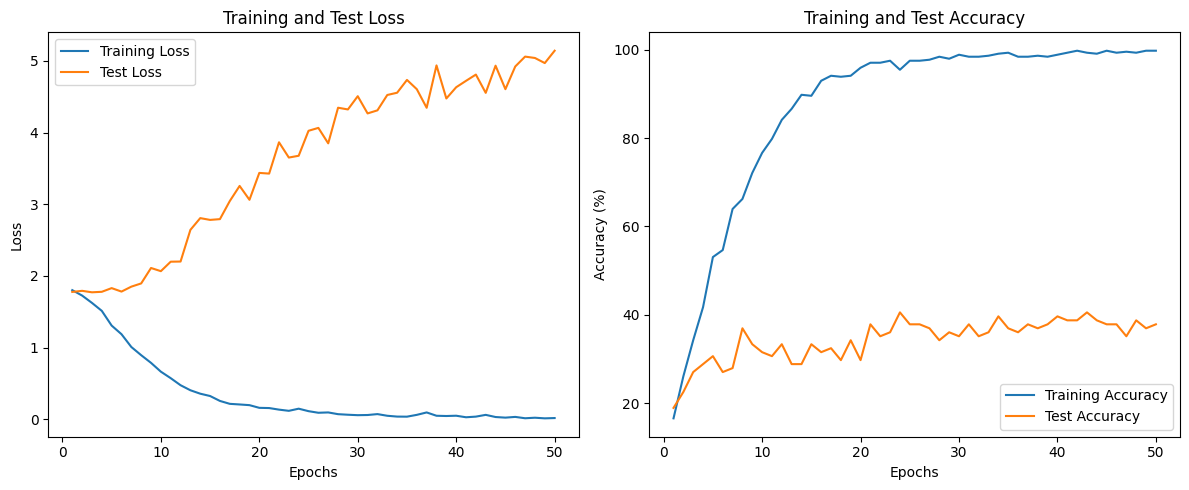

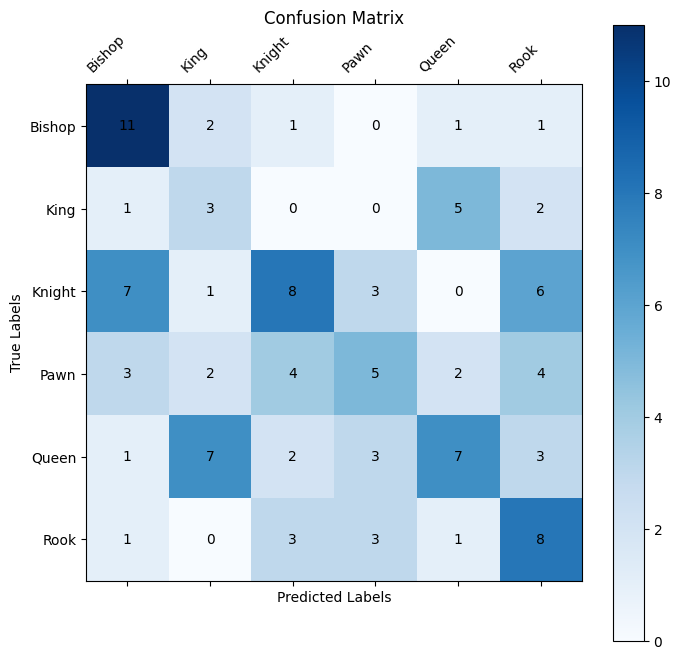

In [12]:
# Configuración inicial
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)

# Entrenamiento
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, [], epochs=50)

(Con parada temprana)

Epoch 1, Training Loss: 1.8163694867065974, Training Accuracy: 16.55328798185941%
Epoch 1, Test Loss: 1.7842916931424821, Test Accuracy: 21.62162162162162%
Epoch 2, Training Loss: 1.734060823917389, Training Accuracy: 26.077097505668934%
Epoch 2, Test Loss: 1.7672965015683855, Test Accuracy: 24.324324324324323%
Epoch 3, Training Loss: 1.633994540997914, Training Accuracy: 35.82766439909297%
Epoch 3, Test Loss: 1.7706555809293474, Test Accuracy: 26.126126126126128%
Epoch 4, Training Loss: 1.500747378383364, Training Accuracy: 40.136054421768705%
Epoch 4, Test Loss: 1.7308790683746338, Test Accuracy: 26.126126126126128%
Epoch 5, Training Loss: 1.2812873699835368, Training Accuracy: 53.28798185941043%
Epoch 5, Test Loss: 1.8548678840909685, Test Accuracy: 30.63063063063063%
Epoch 6, Training Loss: 1.1057242069925581, Training Accuracy: 59.863945578231295%
Epoch 6, Test Loss: 1.9300852843693324, Test Accuracy: 33.333333333333336%
Epoch 7, Training Loss: 0.9664606345551354, Training Accurac

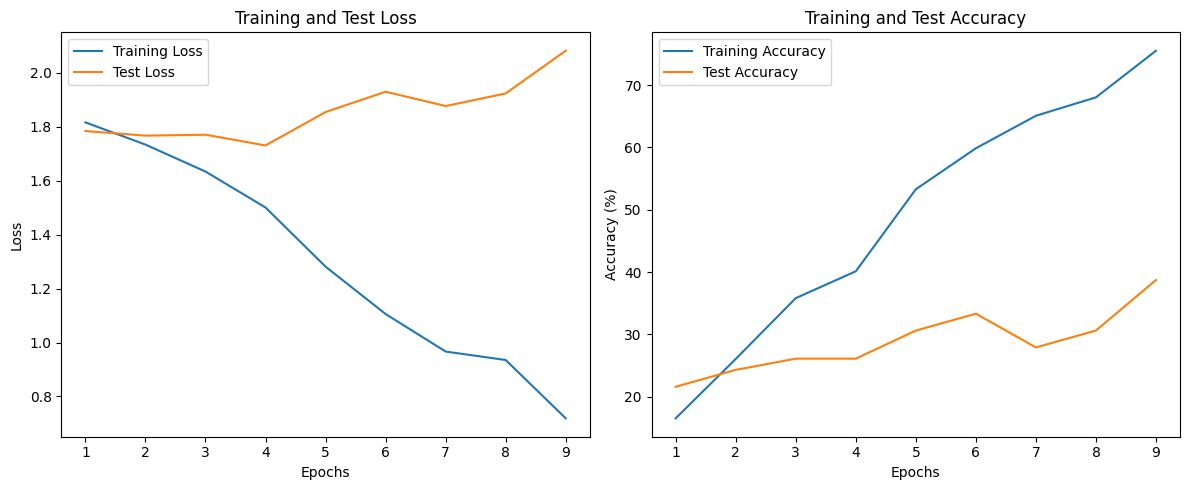

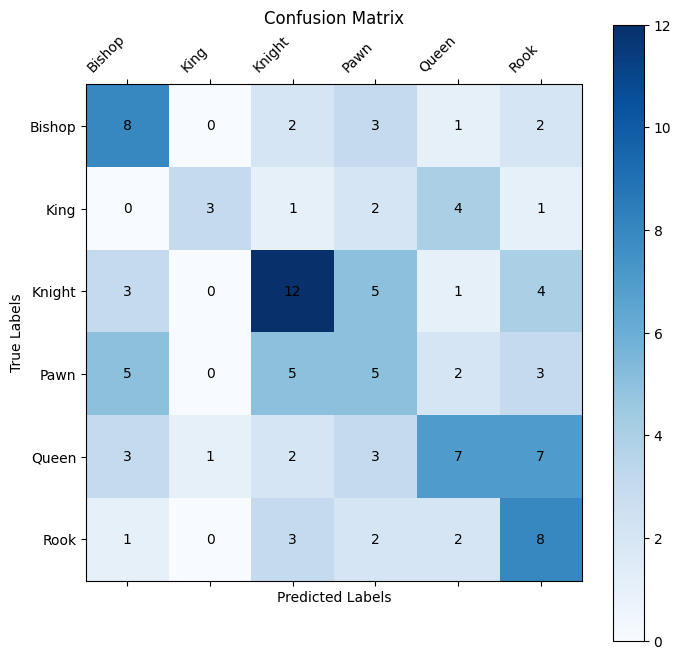

In [15]:
model = ConvNet(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)


Usando 4 capas convolutivas

Epoch 1, Training Loss: 1.790138908794948, Training Accuracy: 17.46031746031746%
Epoch 1, Test Loss: 1.7914003814969743, Test Accuracy: 17.117117117117118%
Epoch 2, Training Loss: 1.7803009450435638, Training Accuracy: 19.727891156462587%
Epoch 2, Test Loss: 1.796959468296596, Test Accuracy: 19.81981981981982%
Epoch 3, Training Loss: 1.7454923859664373, Training Accuracy: 23.80952380952381%
Epoch 3, Test Loss: 1.8217848539352417, Test Accuracy: 18.01801801801802%
Epoch 4, Training Loss: 1.692101457289287, Training Accuracy: 26.984126984126984%
Epoch 4, Test Loss: 1.8368065186909266, Test Accuracy: 18.91891891891892%
Epoch 5, Training Loss: 1.597687955413546, Training Accuracy: 32.87981859410431%
Epoch 5, Test Loss: 1.7642802170344762, Test Accuracy: 26.126126126126128%
Epoch 6, Training Loss: 1.446791450892176, Training Accuracy: 44.21768707482993%
Epoch 6, Test Loss: 1.613196781703404, Test Accuracy: 35.13513513513514%
Epoch 7, Training Loss: 1.2735348727021898, Training Accuracy: 50.

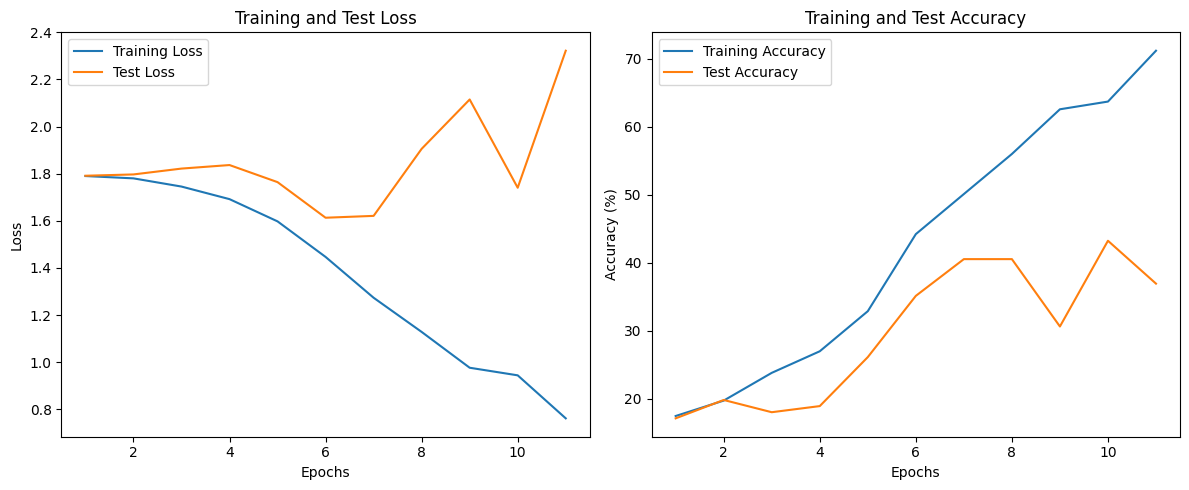

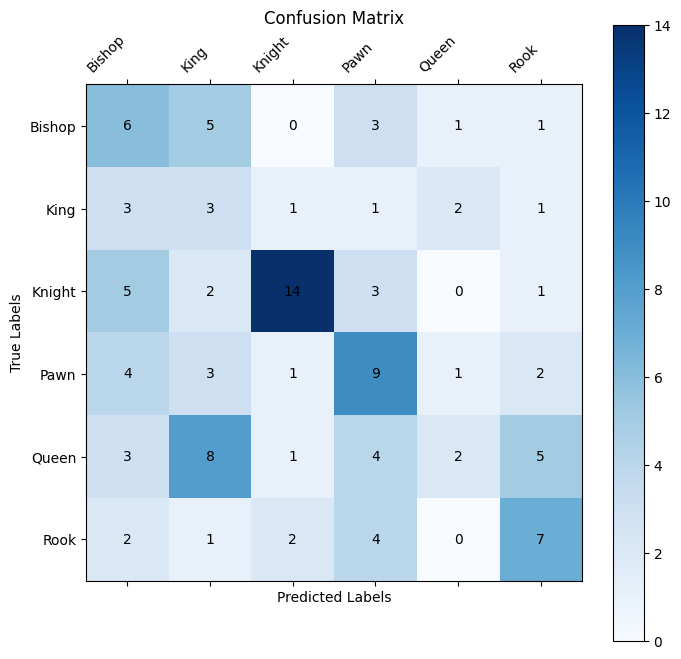

In [16]:
model = ConvNet2(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

6 capas convolutivas y dropout

Epoch 1, Training Loss: 1.7889515374388014, Training Accuracy: 19.047619047619047%
Epoch 1, Test Loss: 1.797343645777021, Test Accuracy: 16.216216216216218%
Epoch 2, Training Loss: 1.7753699719905853, Training Accuracy: 18.140589569160998%
Epoch 2, Test Loss: 1.8758686780929565, Test Accuracy: 14.414414414414415%
Epoch 3, Training Loss: 1.792458666222436, Training Accuracy: 18.594104308390023%
Epoch 3, Test Loss: 1.7938628196716309, Test Accuracy: 14.414414414414415%
Epoch 4, Training Loss: 1.7818043615136827, Training Accuracy: 18.820861678004537%
Epoch 4, Test Loss: 1.7971818958009993, Test Accuracy: 14.414414414414415%
Epoch 5, Training Loss: 1.7711041229111808, Training Accuracy: 17.913832199546484%
Epoch 5, Test Loss: 1.7667874779020036, Test Accuracy: 16.216216216216218%
Epoch 6, Training Loss: 1.7512980188642229, Training Accuracy: 18.140589569160998%
Epoch 6, Test Loss: 1.752826111657279, Test Accuracy: 17.117117117117118%
Epoch 7, Training Loss: 1.7417960933276586, Training Ac

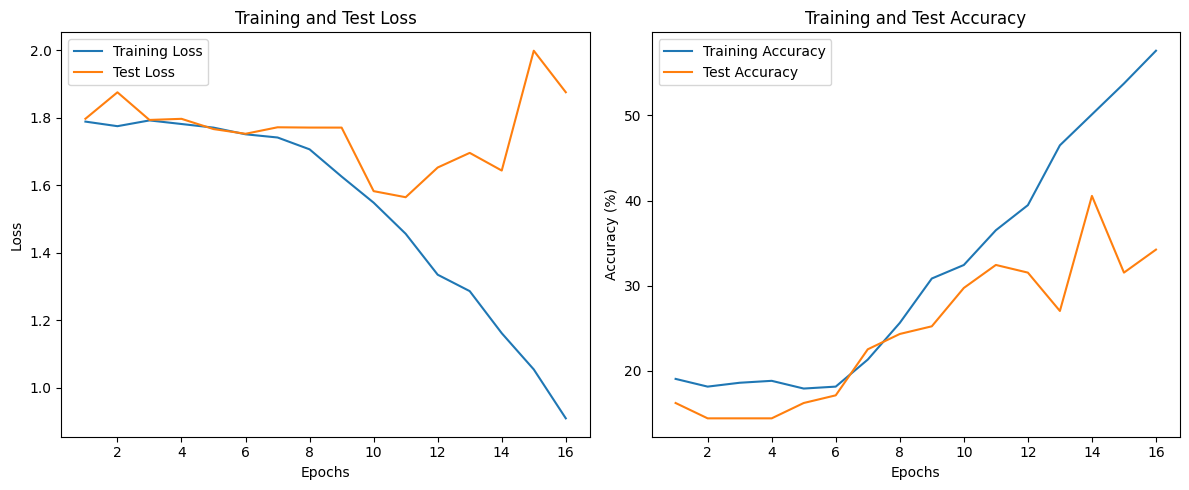

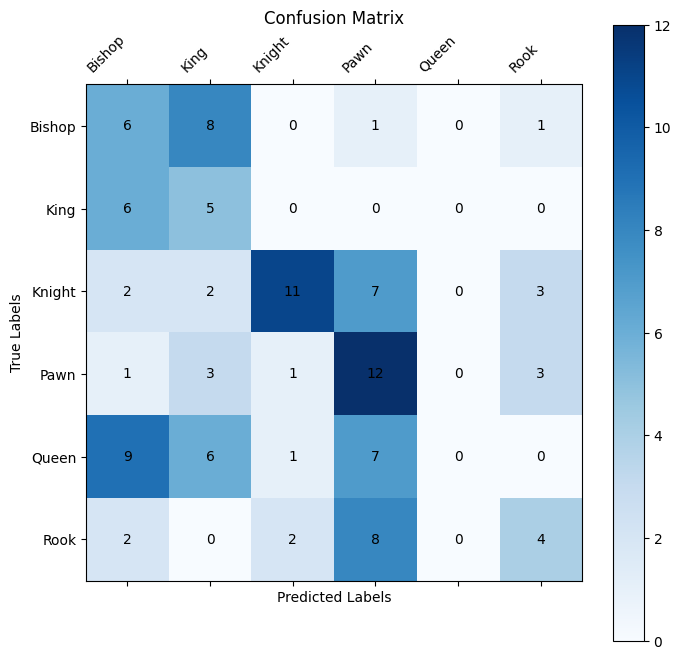

In [17]:
model = ConvNet3(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50)

Vamos a utilizar OpenCV para preprocesar las imágenes.

In [21]:
import cv2
import os
import numpy as np

def detect_edges_and_refine(image_path, save_processed_image=False, output_dir=None, fraction=1/2, grosor=1):
    """
    Aplica detección de bordes, engrosa las líneas detectadas, encuentra los contornos y la recorta según la fración indicada.
    
    Args:
        image_path (str): Ruta de la imagen a procesar.
        save_processed_image (bool): Si es True, guarda la imagen procesada.
        output_dir (str): Directorio donde guardar la imagen procesada si save_processed_image es True.
        fraction (float): Proporción de la imagen que se recorta.
    
    Returns:
        image (np.array): Imagen procesada con bordes engrosados y la mitad superior recortada.
    """
    if not os.path.exists(image_path.replace("\\", "/")):
        print(f"Error: La imagen {image_path.replace('\\', '/')} no existe.")
        return None

    image = cv2.imread(image_path.replace("\\", "/"))
    if image is None:
        print(f"Error: No se pudo cargar la imagen en {image_path.replace('\\', '/')}.\nPosiblemente esté dañada o el formato no es compatible.")
        return None

    image_resized = cv2.resize(image, (256, 256))
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    edges = cv2.Canny(blurred, threshold1=50, threshold2=200)

    kernel = np.ones((3, 3), np.uint8)
    thick_edges = cv2.dilate(edges, kernel, iterations=2)

    contours, _ = cv2.findContours(thick_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = np.zeros_like(image_resized)
    cv2.drawContours(contour_image, contours, -1, (255, 255, 255), grosor)

    height, _ = contour_image.shape[:2]
    if not (0 < fraction <= 1):
        raise ValueError("fraction debe estar en el rango (0, 1].")
    upper_fraction = contour_image[:int(height * fraction), :]

    if save_processed_image and output_dir:
        os.makedirs(output_dir, exist_ok=True)
        processed_image_path = os.path.join(output_dir, os.path.basename(image_path))
        
        cv2.imwrite(processed_image_path, upper_fraction)
    
    return upper_fraction


def process_dataset(input_dir, output_dir, fraction = 1/2, grosor=1):
    """
    Procesa un conjunto de imágenes en un directorio, aplica detección de bordes, engrosa las líneas, encuentra contornos y la recorta según la fracción indicada.
    
    Args:
        input_dir (str): Directorio de entrada con imágenes organizadas por clases.
        output_dir (str): Directorio donde guardar las imágenes procesadas.
        fraction (float): Proporción de la imagen que se recorta.
    """
    os.makedirs(output_dir, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_name)
        if os.path.isdir(class_path):
            output_class_path = os.path.join(output_dir, class_name)
            os.makedirs(output_class_path, exist_ok=True)

            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                try:
                    processed_image = detect_edges_and_refine(
                        image_path, save_processed_image=True, output_dir=output_class_path, fraction=fraction, grosor=grosor
                    )
                except Exception as e:
                    print(f"Error procesando {image_name}: {e}")

In [22]:
input_dataset_dir = "data/raw/Chess"

output_processed_dir = "data/processed/Chess-processed1"
process_dataset(input_dataset_dir, output_processed_dir, 1/2, 1)

output_processed_dir = "data/processed/Chess-processed2"
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 2)

output_processed_dir = "data/processed/Chess-processed3"
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 6)

output_processed_dir = "data/processed/Chess-processed4"
process_dataset(input_dataset_dir, output_processed_dir, 2/3, 10)

Error: No se pudo cargar la imagen en data/raw/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error: No se pudo cargar la imagen en data/raw/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error: No se pudo cargar la imagen en data/raw/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.
Error: No se pudo cargar la imagen en data/raw/Chess/Bishop/00000095.gif.
Posiblemente esté dañada o el formato no es compatible.


In [23]:
class ConvNet4(nn.Module):
    def __init__(self, classes):
        super(ConvNet4, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(512, len(classes))
        self.classes = classes
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        #print(x.shape)
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x)) 
        x = self.dropout(x)
        x = self.fc2(x) 
        
        return x

class ConvNet5(nn.Module):
    def __init__(self, classes):
        super(ConvNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(1024 * 1*1, 2048)
        self.fc2 = nn.Linear(2048, len(classes))
        self.classes = classes

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        #print(x.shape)
        x = x.view(-1, 1024 * 1*1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [24]:
# Transformaciones avanzadas para el conjunto de entrenamiento
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.5, saturation=0.4, hue=0.4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [25]:
# Ruta de las imágenes
data_path = 'data/processed/Chess-processed1'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


Epoch 1, Training Loss: 1.7963449614388602, Training Accuracy: 17.006802721088434%
Epoch 1, Test Loss: 1.78306245803833, Test Accuracy: 22.52252252252252%
Epoch 2, Training Loss: 1.7906768066542489, Training Accuracy: 17.913832199546484%
Epoch 2, Test Loss: 1.7835362298148019, Test Accuracy: 16.216216216216218%
Epoch 3, Training Loss: 1.786807268857956, Training Accuracy: 17.46031746031746%
Epoch 3, Test Loss: 1.780590602329799, Test Accuracy: 19.81981981981982%
Epoch 4, Training Loss: 1.7843740454741888, Training Accuracy: 18.820861678004537%
Epoch 4, Test Loss: 1.7794244119099207, Test Accuracy: 16.216216216216218%
Epoch 5, Training Loss: 1.7865545664514815, Training Accuracy: 16.55328798185941%
Epoch 5, Test Loss: 1.779828327042716, Test Accuracy: 16.216216216216218%
Epoch 6, Training Loss: 1.7833702649388994, Training Accuracy: 15.419501133786849%
Epoch 6, Test Loss: 1.7775450944900513, Test Accuracy: 17.117117117117118%
Parada temprana activada. No hay mejora en la pérdida de vali

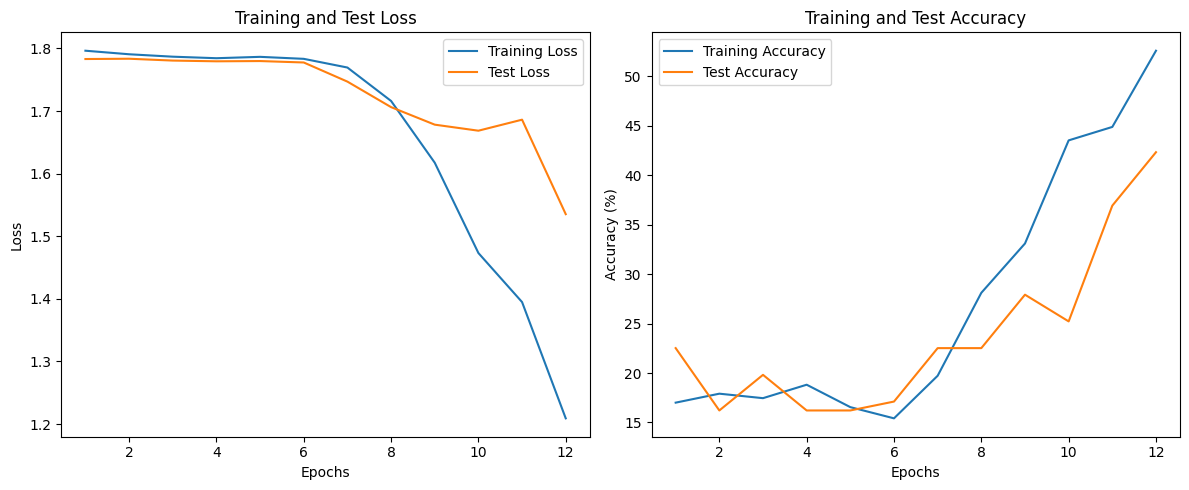

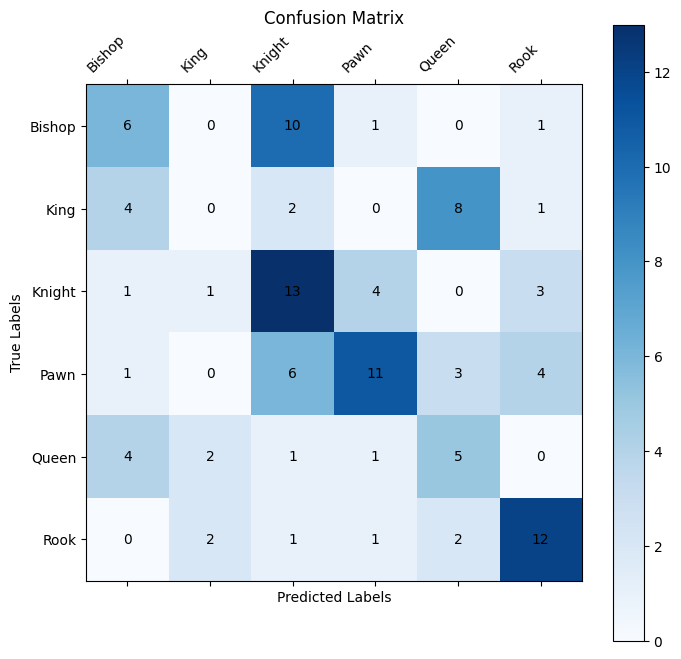

In [30]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0004)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

In [31]:
# Ruta de las imágenes
data_path = 'data/processed/Chess-processed2'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


Epoch 1, Training Loss: 1.795768209866115, Training Accuracy: 16.780045351473923%
Epoch 1, Test Loss: 1.7843233346939087, Test Accuracy: 17.117117117117118%
Epoch 2, Training Loss: 1.7876741417816706, Training Accuracy: 17.687074829931973%
Epoch 2, Test Loss: 1.7805522169385637, Test Accuracy: 17.117117117117118%
Epoch 3, Training Loss: 1.7837689816951752, Training Accuracy: 18.820861678004537%
Epoch 3, Test Loss: 1.7288318020956857, Test Accuracy: 27.027027027027028%
Epoch 4, Training Loss: 1.695906332560948, Training Accuracy: 25.396825396825395%
Epoch 4, Test Loss: 1.6576775482722692, Test Accuracy: 23.423423423423422%
Epoch 5, Training Loss: 1.6316800798688615, Training Accuracy: 31.292517006802722%
Epoch 5, Test Loss: 1.4891104187284196, Test Accuracy: 35.13513513513514%
Epoch 6, Training Loss: 1.4919646765504564, Training Accuracy: 32.6530612244898%
Epoch 6, Test Loss: 1.3657935006277901, Test Accuracy: 35.13513513513514%
Epoch 7, Training Loss: 1.2860519886016846, Training Accur

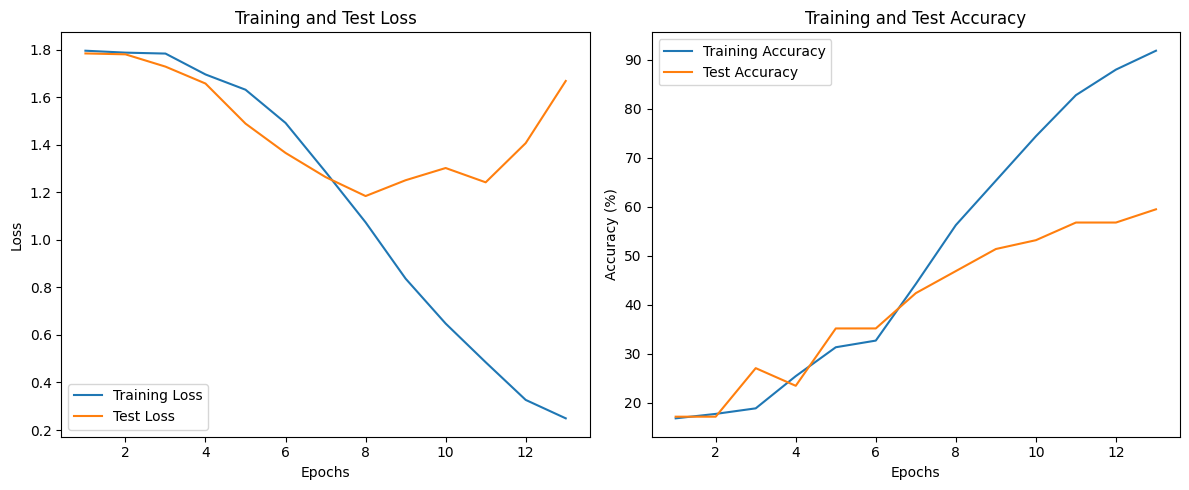

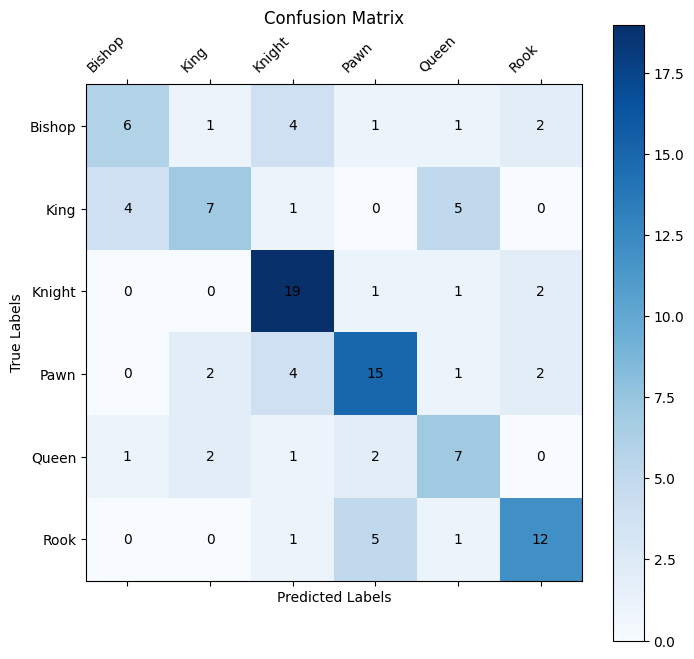

In [32]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

In [33]:
# Ruta de las imágenes
data_path = 'data/processed/Chess-processed3'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Epoch 1, Training Loss: 1.800229787826538, Training Accuracy: 16.780045351473923%
Epoch 1, Test Loss: 1.7860718369483948, Test Accuracy: 19.81981981981982%
Epoch 2, Training Loss: 1.7865268417767115, Training Accuracy: 19.047619047619047%
Epoch 2, Test Loss: 1.7704996466636658, Test Accuracy: 21.62162162162162%
Epoch 3, Training Loss: 1.7609194772584098, Training Accuracy: 20.634920634920636%
Epoch 3, Test Loss: 1.7096149325370789, Test Accuracy: 23.423423423423422%
Epoch 4, Training Loss: 1.683994906289237, Training Accuracy: 29.478458049886623%
Epoch 4, Test Loss: 1.6673723459243774, Test Accuracy: 28.82882882882883%
Epoch 5, Training Loss: 1.5587246673447746, Training Accuracy: 37.641723356009074%
Epoch 5, Test Loss: 1.5616128146648407, Test Accuracy: 33.333333333333336%
Epoch 6, Training Loss: 1.3551520279475622, Training Accuracy: 47.84580498866213%
Epoch 6, Test Loss: 1.600354552268982, Test Accuracy: 41.44144144144144%
Epoch 7, Training Loss: 1.1292551968778883, Training Accurac

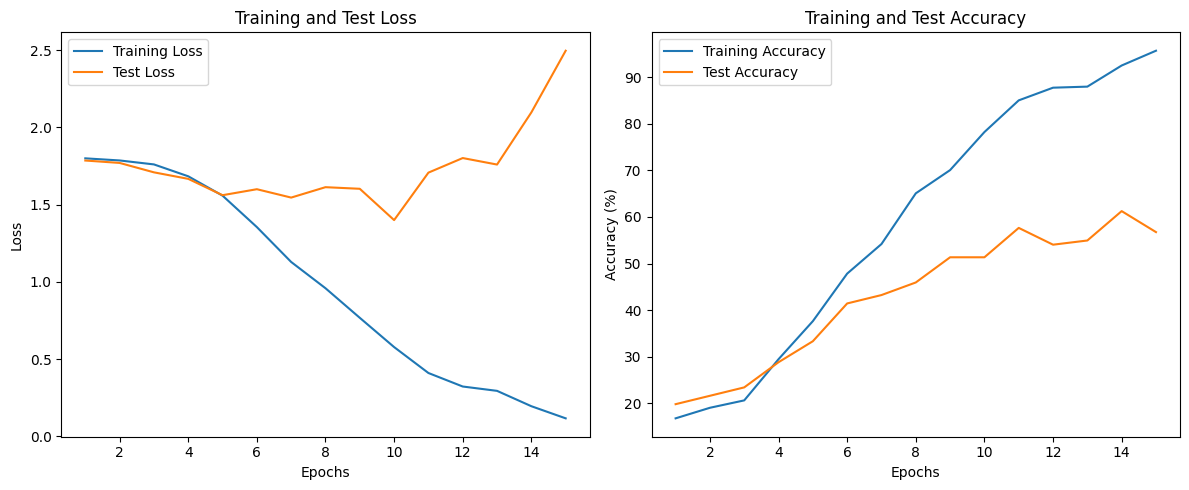

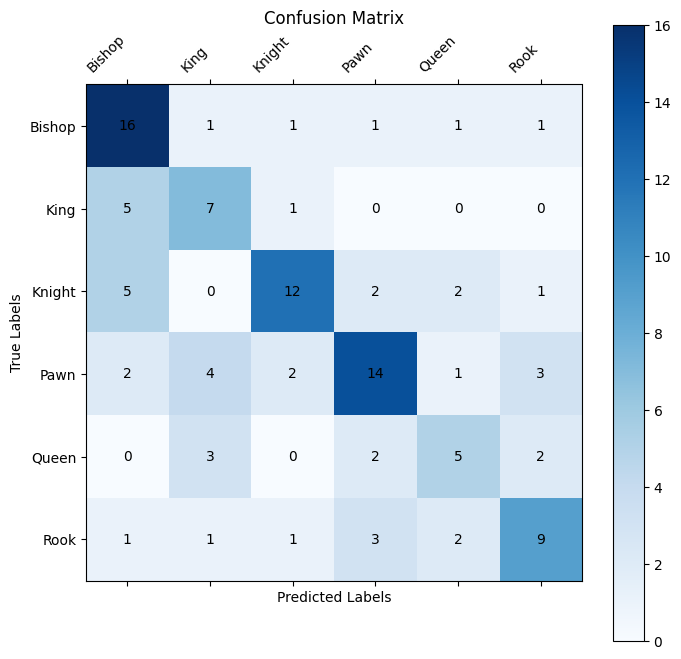

In [34]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Epoch 1, Training Loss: 1.7973501511982508, Training Accuracy: 16.3265306122449%
Epoch 1, Test Loss: 1.779563456773758, Test Accuracy: 19.81981981981982%
Epoch 2, Training Loss: 1.7839510696274894, Training Accuracy: 17.913832199546484%
Epoch 2, Test Loss: 1.774446278810501, Test Accuracy: 15.315315315315315%
Epoch 3, Training Loss: 1.7691864797047205, Training Accuracy: 18.594104308390023%
Epoch 3, Test Loss: 1.7683838605880737, Test Accuracy: 19.81981981981982%
Epoch 4, Training Loss: 1.7416487506457738, Training Accuracy: 18.820861678004537%
Epoch 4, Test Loss: 1.7305391430854797, Test Accuracy: 25.225225225225227%
Epoch 5, Training Loss: 1.7087866238185339, Training Accuracy: 25.396825396825395%
Epoch 5, Test Loss: 1.831166684627533, Test Accuracy: 19.81981981981982%
Epoch 6, Training Loss: 1.6710609623364039, Training Accuracy: 25.170068027210885%
Epoch 6, Test Loss: 1.6647889912128448, Test Accuracy: 27.027027027027028%
Epoch 7, Training Loss: 1.6619153448513575, Training Accurac

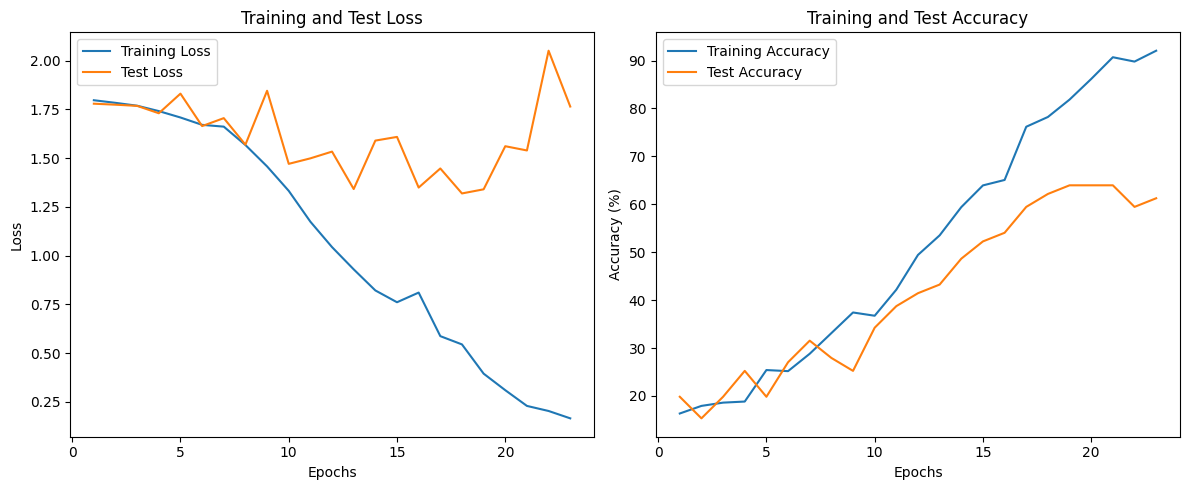

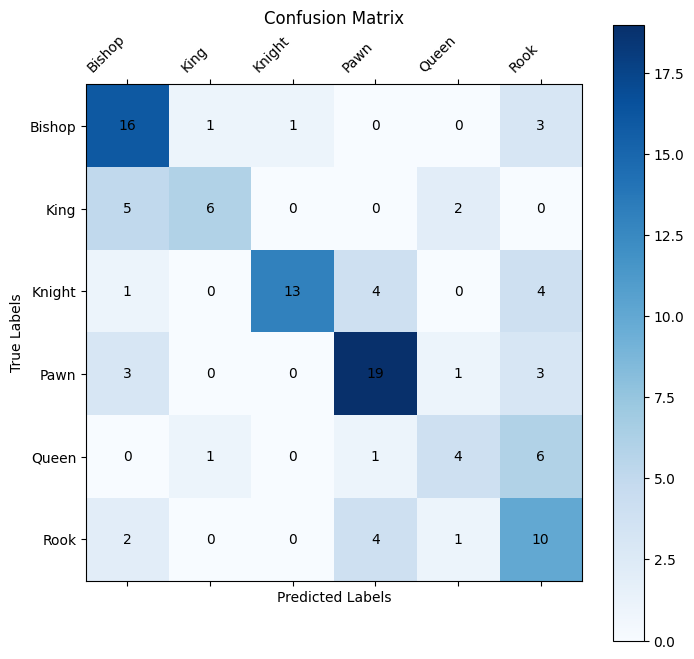

In [36]:
model = ConvNet5(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

In [37]:
# Ruta de las imágenes
data_path = 'data/processed/Chess-processed4'

# Cargamos todas las imágenes de la carpeta con ImageFolder para ambos conjuntos
full_data = datasets.ImageFolder(root=data_path)

# Dividimos en 80% entrenamiento y 20% prueba
train_size = int(0.8 * len(full_data))  # 80% para entrenamiento
test_size = len(full_data) - train_size  # 20% para prueba
train_data, test_data = random_split(full_data, [train_size, test_size])

# Aplicamos las transformaciones a cada conjunto
train_data.dataset.transform = train_transform
test_data.dataset.transform = test_transform

# DataLoaders para el conjunto de entrenamiento y prueba
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Epoch 1, Training Loss: 1.7928229825837272, Training Accuracy: 17.006802721088434%
Epoch 1, Test Loss: 1.8272282183170319, Test Accuracy: 14.414414414414415%
Epoch 2, Training Loss: 1.7688128181866236, Training Accuracy: 19.727891156462587%
Epoch 2, Test Loss: 1.7665221989154816, Test Accuracy: 19.81981981981982%
Epoch 3, Training Loss: 1.6830583555357796, Training Accuracy: 29.25170068027211%
Epoch 3, Test Loss: 1.6824916005134583, Test Accuracy: 30.63063063063063%
Epoch 4, Training Loss: 1.6073032702718462, Training Accuracy: 32.87981859410431%
Epoch 4, Test Loss: 1.5782245993614197, Test Accuracy: 36.93693693693694%
Epoch 5, Training Loss: 1.463347920349666, Training Accuracy: 41.043083900226755%
Epoch 5, Test Loss: 1.47781702876091, Test Accuracy: 39.63963963963964%
Epoch 6, Training Loss: 1.220778226852417, Training Accuracy: 49.20634920634921%
Epoch 6, Test Loss: 1.2931772768497467, Test Accuracy: 48.648648648648646%
Epoch 7, Training Loss: 1.063762217760086, Training Accuracy: 5

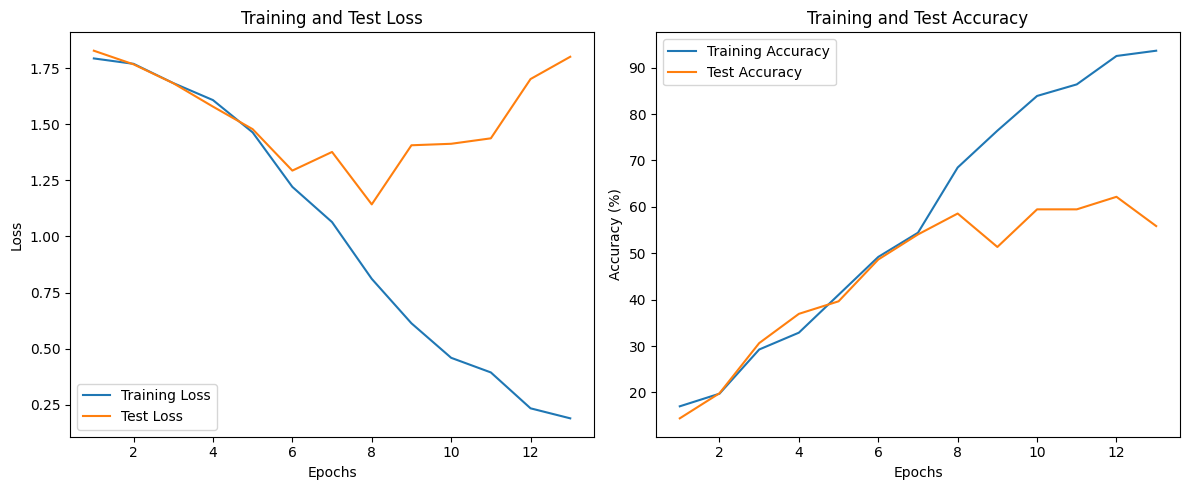

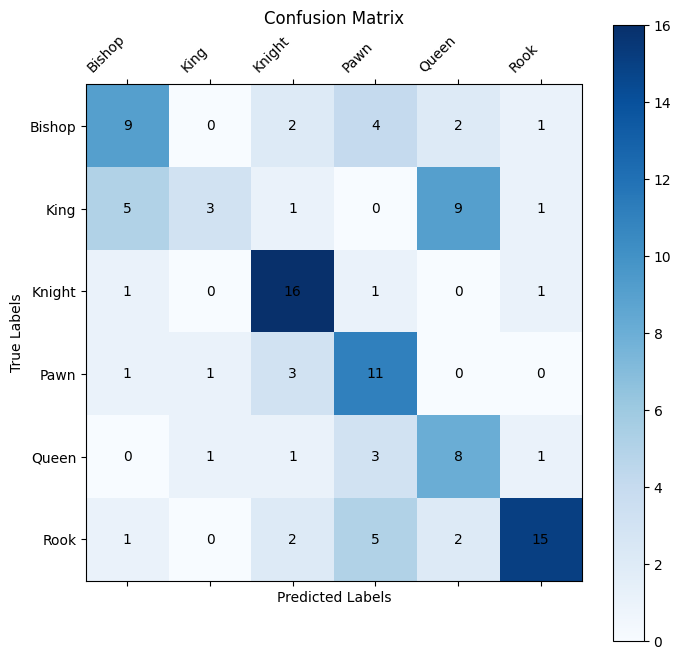

In [41]:
model = ConvNet4(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)

Epoch 1, Training Loss: 1.866878969328744, Training Accuracy: 17.233560090702948%
Epoch 1, Test Loss: 1.793785959482193, Test Accuracy: 17.117117117117118%
Epoch 2, Training Loss: 1.7863014766148158, Training Accuracy: 19.727891156462587%
Epoch 2, Test Loss: 1.80379056930542, Test Accuracy: 17.117117117117118%
Epoch 3, Training Loss: 1.7757686035973685, Training Accuracy: 19.954648526077097%
Epoch 3, Test Loss: 1.8372372090816498, Test Accuracy: 14.414414414414415%
Epoch 4, Training Loss: 1.7754983391080583, Training Accuracy: 20.634920634920636%
Epoch 4, Test Loss: 1.7882207334041595, Test Accuracy: 14.414414414414415%
Epoch 5, Training Loss: 1.728032912526812, Training Accuracy: 23.356009070294785%
Epoch 5, Test Loss: 1.6873808801174164, Test Accuracy: 27.027027027027028%
Epoch 6, Training Loss: 1.6165907212666102, Training Accuracy: 27.664399092970523%
Epoch 6, Test Loss: 1.622601568698883, Test Accuracy: 24.324324324324323%
Epoch 7, Training Loss: 1.5196865797042847, Training Accur

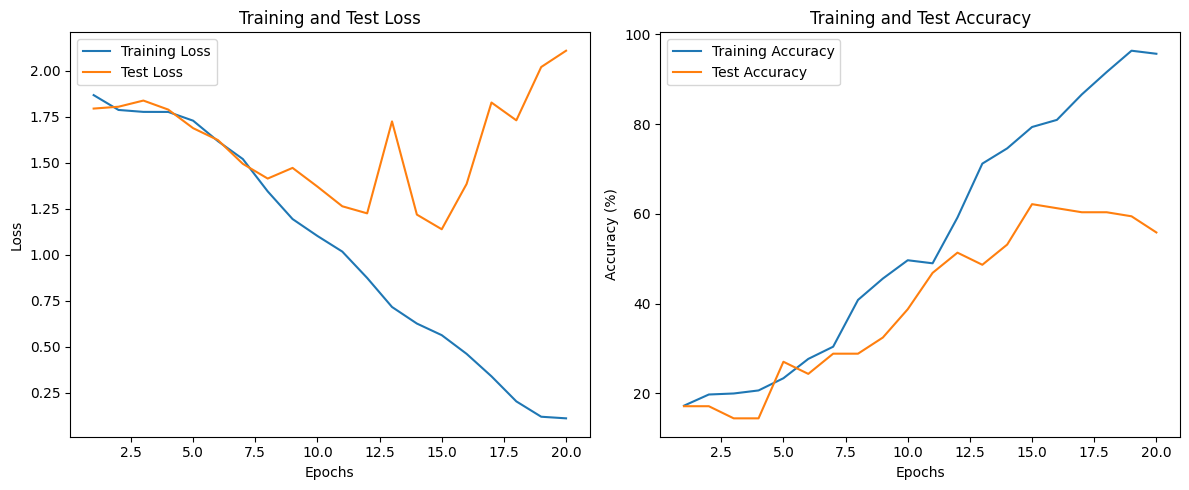

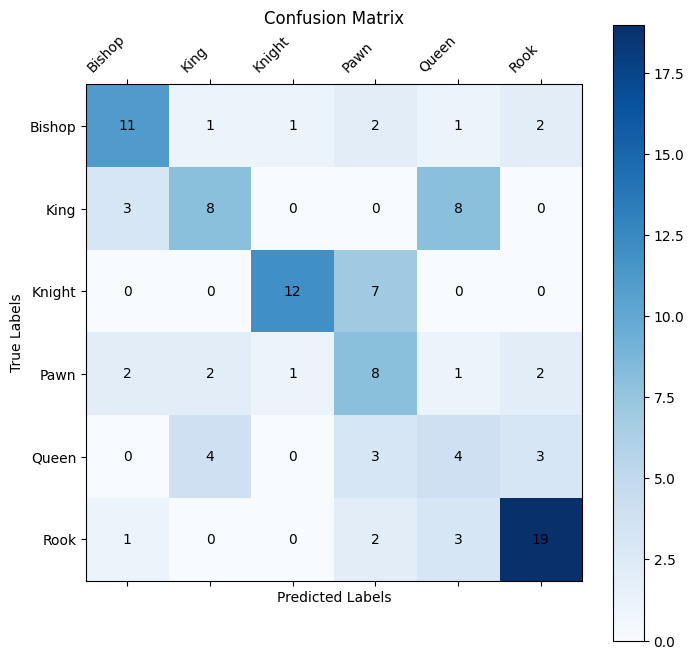

In [43]:
model = ConvNet5(classes=full_data.classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(tolerance=5, min_delta=0.01)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, early_stopping, epochs=50, start_early_stop=10)